## **Задание 1**


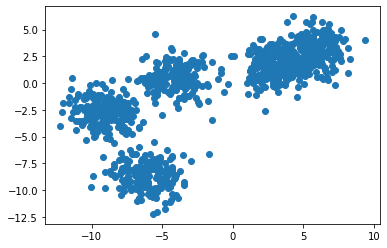

In [252]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from abc import ABC, abstractmethod
from collections import Counter
from sklearn.datasets import make_blobs


X, Y = make_blobs(n_samples = 1000, n_features=2, centers=5, cluster_std = 1.2, random_state=17)
plt.scatter(X[:,0], X[:,1])

In [260]:
class BaseEstimator(ABC):
  @abstractmethod
  def fit(self):
    pass

  @abstractmethod
  def predict(self):
    pass

In [261]:
class KMeans(BaseEstimator):

  def __init__(self, n_clusters=3, eps=.001, max_iter=200, seed=42):
    self.n_clusters = n_clusters
    self.eps = eps
    self.max_iter = max_iter
    self.seed = seed

  def _euclidean_distance(self, obj, data):
    return np.sum((obj - data) ** 2, axis=1)

  def _init_centroids(self, data, n_clusters, seed):
    np.random.seed(self.seed)
    init_indices = np.random.choice(data.shape[0], size=n_clusters)
    return init_indices

  def _calculate_clusters(self, data, centroids):
    data_clusters = []
    for obj in data:
        distances = self._euclidean_distance(obj, centroids)
        data_clusters.append(np.argmin(distances))

    return data_clusters

  def _sse(self, data, centroid):
    return np.sum((data - centroid) **2)

  def fit(self, data):
    centroids_inds = self._init_centroids(data, self.n_clusters, self.seed)
    self.centroids = data[centroids_inds, :]

    for i in range(self.max_iter):

      errors_list = []
      data_clusters = self._calculate_clusters(data, self.centroids)

      old_centroids = self.centroids.copy()
      for cluster in range(self.n_clusters):
        data_in_cluster = data[np.where(np.array(data_clusters) == cluster)]   
        self.centroids[cluster] = data_in_cluster.mean(axis=0)

      errors_list.append(self._sse(data_in_cluster, self.centroids[cluster]))
      self.SSE = np.array(errors_list).mean() 
      
      if (abs(self.centroids - old_centroids < self.eps).all()):
        return

    return

  def predict(self, data):
    data_clusters = self._calculate_clusters(data, self.centroids)
    return np.array(data_clusters)

  def fit_predict(self, data):
    self.fit(data)
    return self.predict(data)

In [262]:
km = KMeans()
km.fit(X)
clusters = km.predict(X)

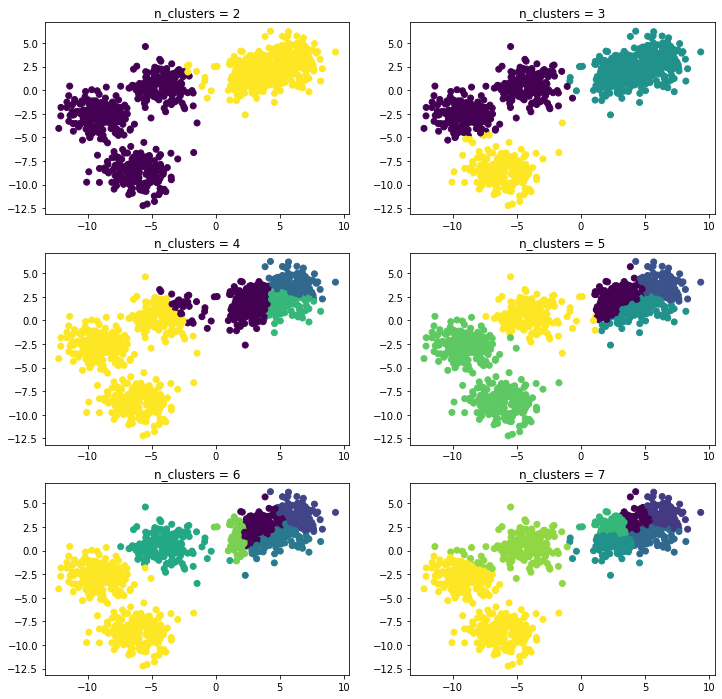

In [263]:
plt.figure(figsize=(12, 12))
for n_c in range(2, 8):
    k_means = KMeans(n_clusters=n_c)
    clusters = k_means.fit_predict(X)
    plt.subplot(3, 2, n_c-1)
    plt.scatter(X[:, 0], X[:, 1], c=clusters)
    plt.title('n_clusters = {}'.format(n_c))
plt.show()

In [266]:
def SSEPlotManual(data, n_clusters=6, max_iter=200, eps=.001, seed=42):
    sse_values = []
    for i in range(1, n_clusters+1):
        km = KMeans(n_clusters=i, max_iter=max_iter, eps=eps, seed=seed)
        km.fit_predict(data)
        sse_values.append(km.SSE)
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(range(1, n_clusters+1), sse_values, color='pink')
    plt.xlabel('NUMBER of Clusters', fontsize=15)
    plt.ylabel('SSE', fontsize=15)
    plt.title('SSE vs NUMBER Of Clusters', fontsize=15)
    plt.grid()
    plt.show()

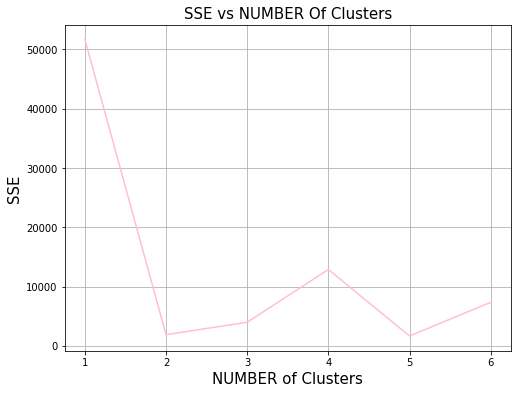

In [267]:
SSEPlotManual(X)

## **Задание 2**

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [162]:
df = pd.read_csv('2.csv', encoding='cp1251')
df = df.drop(columns=['Модель', 'Цвет'])
df.head()

,Марка,Год,Состояние,Пробег,Объем,Топливо,Мощность,Кузов,Привод,КПП,Руль,Хозяев в ПТС,Цена
0,Volkswagen,2013.0,БУ,42000.0,1200.0,бензин,105.0,хэтчбек,передний,автомат,левый,1 владелец,689196.0
1,Skoda,2012.0,БУ,62000.0,1800.0,бензин,152.0,кроссовер,полный,механика,левый,1 владелец,639196.0
2,Renault,2015.0,БУ,4700.0,1600.0,бензин,106.0,хэтчбек,передний,механика,левый,1 владелец,629196.0
3,Nissan,2012.0,БУ,70000.0,1600.0,бензин,110.0,хэтчбек,передний,автомат,левый,1 владелец,479196.0
4,УАЗ,2014.0,БУ,50000.0,2700.0,бензин,128.0,внедорожник,полный,механика,левый,1 владелец,599196.0


In [208]:
df["Топливо"].value_counts()

бензин              31570
дизель               3063
газ                   278
гибридный             106
электродвигатель        2
Name: Топливо, dtype: int64

In [194]:
for cl in df.columns:
  print(f"{cl}: {df[cl].nunique()}")

Марка: 92
Год: 28
Состояние: 1
Пробег: 3443
Объем: 45
Топливо: 5
Мощность: 303
Кузов: 11
Привод: 3
КПП: 4
Руль: 2
Хозяев в ПТС: 3
Цена: 1577
cluster: 5


In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35019 entries, 0 to 61065
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Марка         35019 non-null  object 
 1   Год           35019 non-null  float64
 2   Состояние     35019 non-null  object 
 3   Пробег        35019 non-null  float64
 4   Объем         35019 non-null  float64
 5   Топливо       35019 non-null  object 
 6   Мощность      35019 non-null  float64
 7   Кузов         35019 non-null  object 
 8   Привод        35019 non-null  object 
 9   КПП           35019 non-null  object 
 10  Руль          35019 non-null  object 
 11  Хозяев в ПТС  35019 non-null  object 
 12  Цена          35019 non-null  float64
 13  cluster       35019 non-null  int32  
dtypes: float64(5), int32(1), object(8)
memory usage: 3.9+ MB


In [196]:
num_features = [cl for cl in df.columns if df[cl].dtype == "float64"]
cat_features = [cl for cl in df.columns if df[cl].dtype == "object"]

In [197]:
preprocessor = ColumnTransformer(
transformers=[
  ('num', StandardScaler(), num_features),
  ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)])

In [186]:
def SSEPlot(df, n_clusters=8, max_iter=200, tol=1e-04, init='k-means++', n_init=10):
    inertia_values = []
    for i in range(1, n_clusters+1):
        km = KMeans(n_clusters=i, max_iter=max_iter, tol=tol, init=init, n_init=n_init, random_state=1)
        km.fit_predict(df)
        inertia_values.append(km.inertia_)
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(range(1, n_clusters+1), inertia_values, color='blue')
    plt.xlabel('Number of clusters', fontsize=15)
    plt.ylabel('SSE', fontsize=10)
    plt.title('SSE vs Number of clusters', fontsize=10)
    plt.grid()
    plt.show()

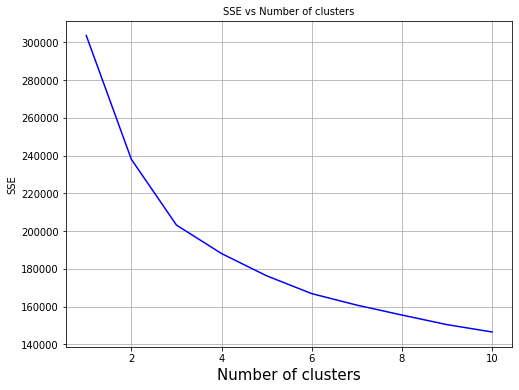

In [198]:
prep_data = preprocessor.fit_transform(df).toarray()
SSEPlot(prep_data, 10)

In [199]:
def clusterization_report_labels(df, clusters):
  df['cluster'] = clusters
  df_enc = df.copy(deep=True)
  labels = []
  for feature in cat_features:
    lenc = LabelEncoder()
    df_enc[feature] = lenc.fit_transform(df[feature])
    labels.append({i : f for i, f in enumerate(lenc.classes_.tolist())})

  res = df_enc.groupby(by="cluster").median()

  for feature, dictinary in zip(cat_features, labels):
    res[feature] = res[feature].map(dictinary)

  return res

In [268]:
km = KMeans(n_clusters=3)
clusters = km.fit_predict(prep_data)
rep = clusterization_report_labels(df, clusters)

In [269]:
rep

,Марка,Год,Состояние,Пробег,Объем,Топливо,Мощность,Кузов,Привод,КПП,Руль,Хозяев в ПТС,Цена
cluster,,,,,,,,,,,,,
0,Opel,2011.0,БУ,82062.5,1600.0,бензин,107.0,седан,передний,механика,левый,2 владельца,400000.0
1,Peugeot,2002.0,БУ,180000.0,1600.0,бензин,102.0,седан,передний,механика,левый,3 и более,180000.0
2,Mercedes-Benz,2010.0,БУ,105000.0,2500.0,бензин,201.0,кроссовер,полный,автомат,левый,2 владельца,950000.0


In [270]:
df_c = df.copy()
df_c['cluster'] = clusters
top_brands = df_c['Топливо'].value_counts()[:15].index

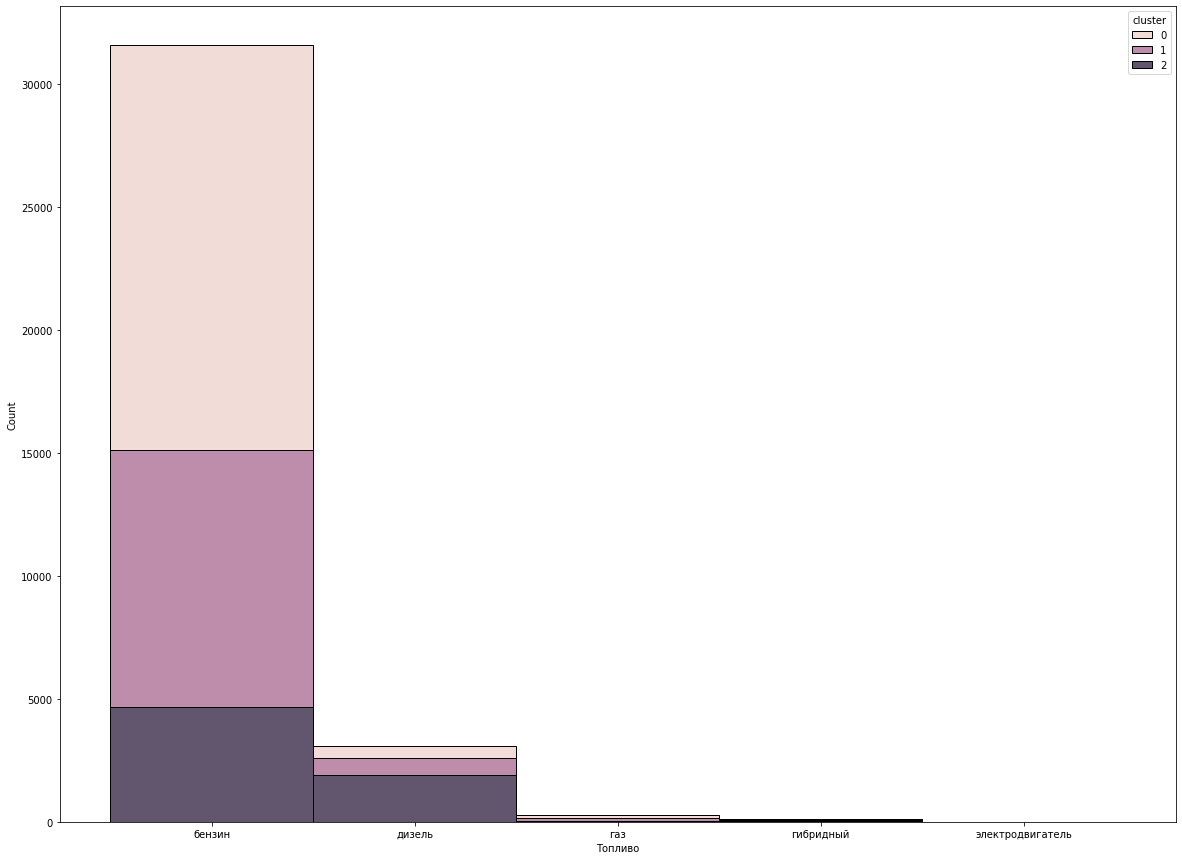

In [271]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.histplot(data=df_c[df_c['Топливо'].isin(top_brands)], x="Топливо", hue='cluster', multiple='stack', color=['Set2'] , ax=ax)